In [1]:
# Base Libraries
import numpy as np
import matplotlib.pyplot as plt

# Organizing Image Data
import os
from PIL import Image

# Timing
from tqdm.auto import tqdm
from time import time

# Torch imports
from torch import device
from torch import cuda
from torch import Generator
from torch import sum
from torch import where
from torch import argmax
from torch import tensor

from torch.utils.data import random_split
from torch.utils.data import DataLoader

from torch.nn import Module
from torch.nn import Linear
from torch.nn import CrossEntropyLoss

from torch import optim

from torchvision import transforms
from torchvision import datasets
from torchvision import models

C:\Users\aaggu\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
path = "C:/Users/aaggu/DataSpell Projects/SF-2024/malaria-cells-dataset"
folders = os.listdir(path)
rescale = 100

for folder in folders:
    files = os.listdir(path + '/' + folder)
    for idx, file in enumerate(tqdm(files, desc="Files Renamed/Resized: ")):
        image = Image.open(os.path.join(path, folder, file))
        image = image.resize((rescale, rescale))
        new_path = os.path.join(path, folder, str(idx))
        image.save(str(new_path) + ".png")

Files Renamed/Resized:   0%|          | 0/16255 [00:00<?, ?it/s]

Files Renamed/Resized:   0%|          | 0/13779 [00:00<?, ?it/s]

In [62]:
class ResNetClassifier(Module):
    def __init__(self, lr, tol, batch_size, epochs, num_classes, scale, data_path, seed):
        super(ResNetClassifier, self).__init__()


        self.lr = lr
        self.tol = tol
        self.batch_size = batch_size
        self.epochs = epochs
        self.num_classes = num_classes
        self.scale = scale
        self.data_path = data_path
        self.seed = seed
        self.device = device("cuda" if cuda.is_available() else "cpu")

        self.loss_history = []
        self.acc_history = []
        self.epoch_acc_history = []
        self.test_loss = -1
        self.test_acc = -1

        self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT).to(self.device)

        self.in_dims = self.model.fc.in_features
        self.fc = Linear(in_features=self.in_dims, out_features=num_classes)
        self.loss = CrossEntropyLoss()
        self.optimizer = optim.AdamW(self.parameters(), lr = self.lr)

        self.to(self.device)

        self.train_data_loader = None
        self.test_data_loader = None
        self.get_data()


    def forward(self, batch_data):
        batch_data = batch_data.clone().detach().to(self.device)
        output = self.model(batch_data)
        return output


    def get_data(self):
        tf = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])

        all_data = datasets.ImageFolder(self.data_path, transform=tf)
        train_data, test_data = random_split(all_data, [0.75, 0.25],
                                             generator=Generator().manual_seed(self.seed))
        self.train_data_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True, num_workers=4)
        self.test_data_loader = DataLoader(test_data, batch_size=self.batch_size, shuffle=True, num_workers=4)


    def train_(self):
        time_started = time()

        for i in range(self.epochs):
            header = f"Epoch {i+1}/{self.epochs}"
            print(header)
            print("-" * len(header))

            loader = self.train_data_loader
            self.train()

            # For plotting and statistics
            epoch_loss = 0
            epoch_acc = []

            # Main training loop
            for in_data, label in loader:
                self.optimizer.zero_grad()

                # Get model prediction and determine how well it did
                label = label.to(self.device)
                prediction = self.forward(in_data)
                classes = argmax(prediction, dim=1)

                wrong = where(tensor(classes != label).to(self.device),
                              tensor([1.]).to(self.device),
                              tensor([0.]).to(self.device))

                # Calculate loss and accuracy
                acc = 1 - sum(wrong) / self.batch_size
                batch_loss = self.loss(prediction, label)
                epoch_loss += batch_loss.item()

                # Train through backpropagation
                batch_loss.backward()
                self.optimizer.step()

                # Statistics
                self.acc_history.append(acc.item())
                epoch_acc.append(acc.item())

            elapsed = time() - time_started
            print(f"Finished epoch {i+1} with loss {epoch_loss} and accuracy of {np.mean(epoch_acc)} in time "
                  f"{int((elapsed // 60) // 60)}:{int(elapsed // 60)}:{int(elapsed % 60)}")

            self.loss_history.append(epoch_loss)
            self.epoch_acc_history.append(np.mean(epoch_acc))
            print()

        print("Training complete...")


    def test_(self):
        self.eval()

        time_started = time()
        total_loss = 0
        total_acc = []

        for in_data, label in self.test_data_loader:

            # Compare correct answers to model
            label = label.to(self.device)
            prediction = self.forward(in_data)
            classes = argmax(prediction, dim=1)

            wrong = where(tensor(classes != label).to(self.device),
                          tensor([1.]).to(self.device),
                          tensor([0.]).to(self.device))

            acc = 1 - sum(wrong) / self.batch_size
            batch_loss = self.loss(prediction, label)

            total_acc.append(acc.item())
            total_loss += batch_loss.item()

        elapsed = int(time() - time_started)
        self.test_acc = np.mean(total_acc)
        self.test_loss = total_loss

        print(f"Finished with loss {self.test_loss} and accuracy of {self.test_acc} in {elapsed // 60}:{elapsed % 60}")

In [55]:
model = ResNetClassifier(lr=0.01, tol=2, batch_size=64, epochs=5, num_classes=2, scale=100, data_path="OBSCURED", seed=251)
model.train_()
model.test_()

Epoch 1/5
---------


C:\Users\aaggu\AppData\Local\Temp\ipykernel_21916\3234399298.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wrong = where(tensor(classes != label).to(self.device),


Finished epoch 1 with loss 2128.2155115902424 and accuracy of 0.6825727982954546 in time 0:0:39

Epoch 2/5
---------
Finished epoch 2 with loss 193.32961523532867 and accuracy of 0.7336647727272727 in time 0:1:10

Epoch 3/5
---------
Finished epoch 3 with loss 145.65022752806544 and accuracy of 0.8261274857954546 in time 0:1:48

Epoch 4/5
---------
Finished epoch 4 with loss 68.2860736399889 and accuracy of 0.9377219460227273 in time 0:2:25

Epoch 5/5
---------
Finished epoch 5 with loss 64.10123122110963 and accuracy of 0.9403409090909091 in time 0:3:0

Training complete...


C:\Users\aaggu\AppData\Local\Temp\ipykernel_21916\3234399298.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wrong = where(tensor(classes != label).to(self.device),


Finished with loss 31.000053361058235 and accuracy of 0.892478813559322 in 0:29


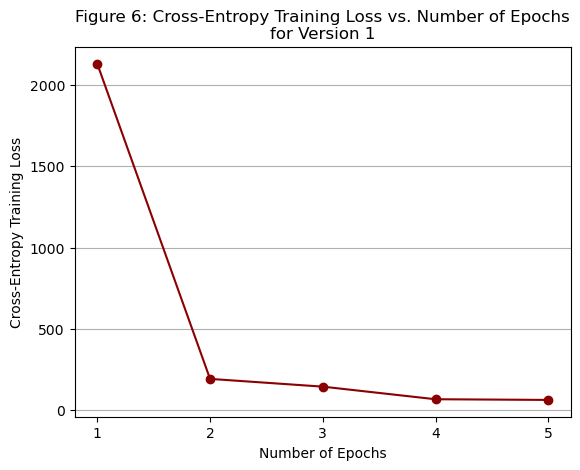

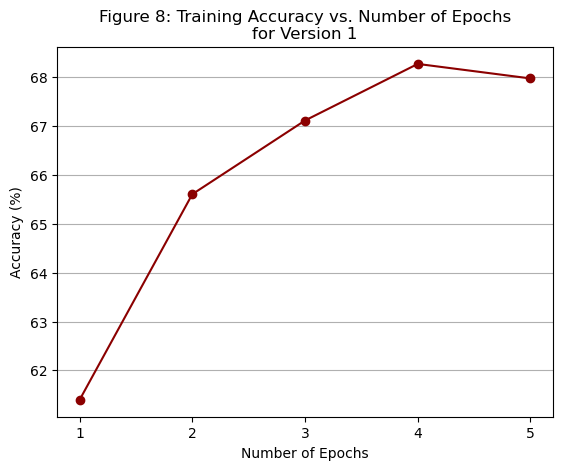

In [77]:
v = input("Enter version #: ")
fig = int(input("Enter figure #: "))
epoch_dims = np.arange(1, len(model.loss_history)+1, 1)
path = 'data-graphs/'
v_num = int(v[0])

# Graph 1
plt.plot(model.loss_history, marker='o', color='darkred')
plt.title(f"Figure {fig}: Cross-Entropy Training Loss vs. Number of Epochs\nfor Version {v_num}")
plt.xlabel("Number of Epochs")
plt.ylabel("Cross-Entropy Training Loss")
plt.xticks(np.arange(len(model.loss_history)), epoch_dims)
plt.grid(axis='y')
plt.savefig(path + 'v' + v + "-train-loss-graph.png", bbox_inches='tight')
plt.show()

# Graph 2
plt.plot(model.epoch_acc_history, marker='o', color='darkred')
plt.title(f"Figure {fig+2}: Training Accuracy vs. Number of Epochs\nfor Version {v_num}")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy (%)")
plt.xticks(np.arange(len(model.epoch_acc_history)), epoch_dims)
plt.grid(axis='y')
plt.savefig(path + 'v' + v + "-epoch-acc-graph.png", bbox_inches='tight')
plt.show()

In [66]:
def write_to(fw, arr, header):
    fw.write(header + '\n[' + str(arr[0]))
    for num in range(1, len(arr)):
        fw.write(', ' + str(arr[num]))
    fw.write(']\n\n')


try: v
except NameError: v = input("Enter version: ")

with open(f'data-graphs/v{v}-data.txt', 'w') as f_out:
    write_to(f_out, model.loss_history, "Training Loss")
    write_to(f_out, model.epoch_acc_history, "Training Accuracy (Per Epoch)")

    f_out.write(f"Testing Loss, Accuracy\n{model.test_loss}, {model.test_acc}\n\n")

    write_to(f_out, model.acc_history, "Training Accuracy (Per Batch)")